In [2]:
# Add this line in Google Colab!
# !pip install POT

In [3]:
import os
import requests

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras as kr

from PIL import Image
from skimage.morphology import dilation,erosion,opening,closing,square,disk

import ot
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import paired_distances

import seaborn as sns
import pandas as pd

2025-04-25 11:26:47.866936: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-25 11:26:47.874029: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745591207.882134   24429 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745591207.884603   24429 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-25 11:26:47.893435: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# Check if the folder Figures exists:

In [5]:
folder_name = 'Figures'
if not os.path.exists(folder_name):
    try:
        os.makedirs(folder_name)
        print(f"Folder '{folder_name}' created successfully.")
    except OSError as e:
            print(f"Error creating folder '{folder_name}': {e}")
else:
    print(f"Folder '{folder_name}' already exists.")

Folder 'Figures' already exists.


# Read the CIFAR dataset

In [7]:
# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = kr.datasets.cifar10.load_data()

x_train = x_train/255

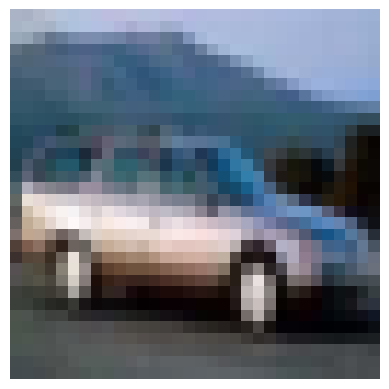

In [8]:
# Select the first Ntr training images;
Ntr = 100
Nval = 100

Xtr = x_train[0:Ntr]
Xval = x_train[Ntr:Ntr+Nval]

# Display the image
for i in range(5):
    plt.imshow(Xtr[i])
    plt.axis(False)
    plt.savefig(folder_name+'/img'+str(i)+'.png', bbox_inches='tight', dpi=300)
    # plt.show()

# Define some lexicographical orderings

In [10]:
# def h_RG(img):
#     return (img[...,0]-img[...,1])**2/(1.e-6+np.sum(img,2))

# def h_GB(img):
#     return (img[...,1]-img[...,2])**2/(1.e-6+np.sum(img,2))

# def h_BR(img):
#     return (img[...,2]-img[...,0])**2/(1.e-6+np.sum(img,2))

# rho_list = [h_RG, h_GB, h_BR]
# rho_list_names = ["h_RG", "h_GB", "h_BR"]

def LexRGB(img):
    return np.dot(img[...,:3], [255, 1, 1/255])

def LexGBR(img):
    return np.dot(img[...,:3], [1/255, 255, 1])

def LexBRG(img):
    return np.dot(img[...,:3], [1, 1/255, 255])

rho_list = [LexRGB, LexGBR, LexBRG]
rho_list_names = ["Lex_RGB", "Lex_GBR", "Lex_BRG"]

# Apply the reduced mappings to the images for the training phase.

In [12]:
Ytr = np.stack([np.stack([rho(x) for rho in rho_list],axis=2) for x in Xtr],axis=0)
Yval = np.stack([np.stack([rho(x) for rho in rho_list],axis=2) for x in Xval],axis=0)

# Show some images

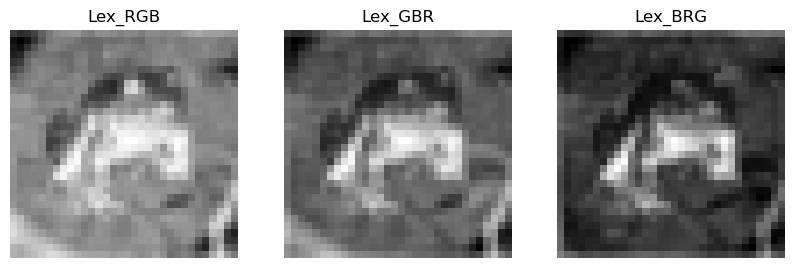

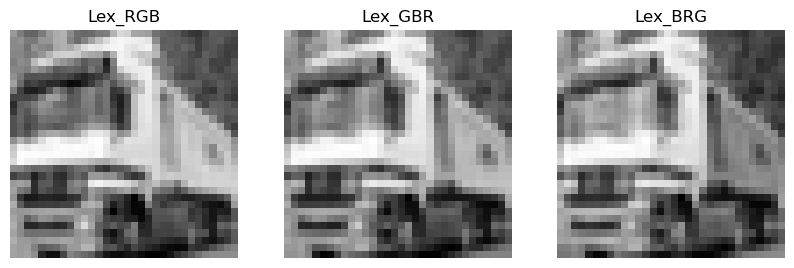

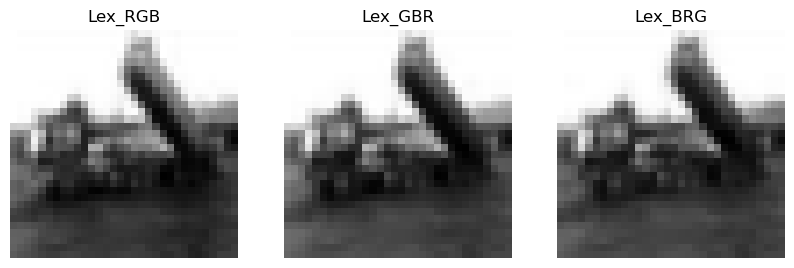

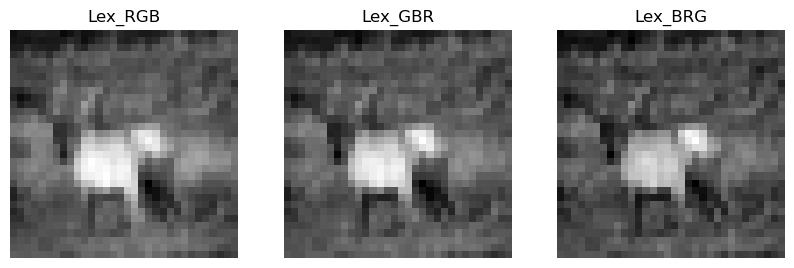

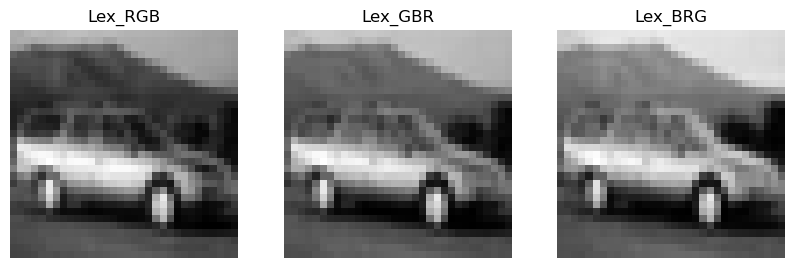

In [14]:
for i in range(5):
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))
    for j in range(len(rho_list)):
        axs[j].imshow(Ytr[i][:,:,j],cmap="gray")
        axs[j].axis(False)
        axs[j].set_title(rho_list_names[j])
    plt.show()

# Compute the (centred) Kendall coding from a list of color values

In [16]:
def Kendall_coding(values):
  # Convert the values to gray and reshape to a column vector
  x = values.reshape(-1,1)
  # Compute the kendall coding
  return 1.0*(x<=x.T)-(x.T<=x)

def Average_Kendall_coding(list_values):
  return np.stack([Kendall_coding(list_values[:,i]) for i in range(list_values.shape[1])],axis=2).mean(axis=2)

In [17]:
Average_Kendall_coding(Ytr[0].reshape(-1,3))[:3,:3]

array([[ 0.        , -1.        , -1.        ],
       [ 1.        ,  0.        ,  0.33333333],
       [ 1.        , -0.33333333,  0.        ]])

# Define a MLP network that converts a color values to a gray-scale values

The network architecture is (3-64-1) with relu activation function in the hidden layer, no activation function and no bias in the output layer. However, because we are working with images, we implemented the using Conv2D layers with (1,1) kernels.

In [19]:
model = kr.Sequential([
    kr.Input(shape=(3,)),
    kr.layers.Dense(64, activation='relu'),
    kr.layers.Dense(1, activation=None, use_bias = False),
    ])

I0000 00:00:1745591213.697543   24429 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9170 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 320 (1.25 KB)

 Trainable params: 320 (1.25 KB)

 Non-trainable params: 0 (0.00 B)

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step


I0000 00:00:1745591214.220070   24586 service.cc:148] XLA service 0x7aad10003a00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745591214.220089   24586 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 SUPER, Compute Capability 8.9
2025-04-25 11:26:54.223651: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745591214.229358   24586 cuda_dnn.cc:529] Loaded cuDNN version 90501
I0000 00:00:1745591214.254098   24586 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


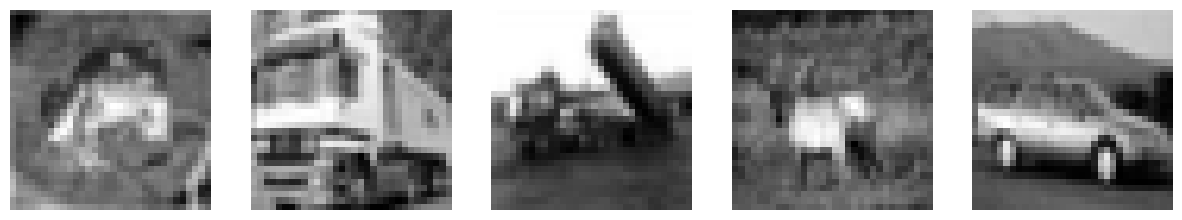

In [21]:
aux = Xtr[:5]

y_pred = model.predict(aux.reshape(-1,3)).reshape(aux.shape[0],aux.shape[1],aux.shape[2])

fig, axs = plt.subplots(1, 5, figsize=(15, 5))

for i in range(5):
    axs[i].imshow(y_pred[i],cmap="gray")
    axs[i].axis(False)
plt.show()

# Define the Kemeny-Young loss



In [23]:
def Kemeny_Young_Loss(y_true, y_pred):
    tau = 1.0
    # Compute the Kendal Average Coding
    K = y_true.shape[1]
    Delta = []
    for i in range(K):
      x =  tf.reshape(y_true[:,i],(-1,1))
      Delta.append(tf.cast(x<=tf.transpose(x),tf.float32)-tf.cast(tf.transpose(x)<=x,tf.float32))
    Delta = tf.reduce_mean(tf.stack(Delta,axis=2),axis=2)
    # Compute Y
    Y = tf.math.sigmoid((y_pred - tf.transpose(y_pred)) / tau)
    return tf.reduce_mean(Delta * Y)

In [24]:
model.compile(optimizer="Adam", loss=Kemeny_Young_Loss)
# model.compile(optimizer=kr.optimizers.Adam(learning_rate=0.0001), loss=Kemeny_Young_Loss)

In [25]:
hist = model.fit(Xtr.reshape(-1,3), Ytr.reshape(-1,3), validation_data=(Xval.reshape(-1,3),Yval.reshape(-1,3)), batch_size=32*32, epochs=100,verbose=True)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: -0.0535 - val_loss: -0.1626
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step - loss: -0.2155 - val_loss: -0.2648
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - loss: -0.3035 - val_loss: -0.3119
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.3390 - val_loss: -0.3376
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - loss: -0.3569 - val_loss: -0.3540
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step - loss: -0.3678 - val_loss: -0.3652
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step - loss: -0.3745 - val_loss: -0.3734
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - loss: -0.3809 - val_loss: -0.3798
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - loss: -0.3835 - val_loss: -0.3849
Epoch 10/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - loss: -0.3866 - val_loss: -0.3891
Epoch 11/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.3888 - val_loss: -0.3927
Epo

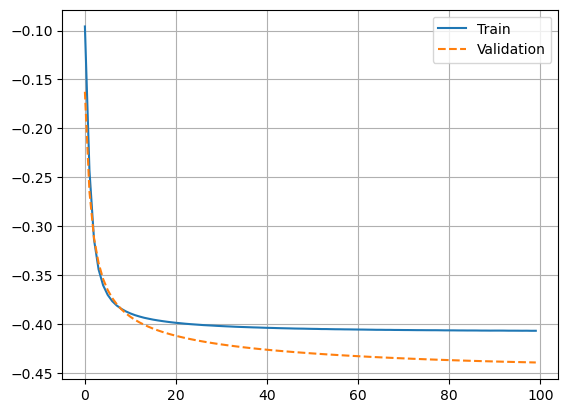

In [26]:
plt.plot(hist.history['loss'],'-',label="Train")
plt.plot(hist.history['val_loss'],'--',label="Validation")
plt.grid()
plt.legend()
plt.savefig(folder_name+'/'+'loss_values.png', bbox_inches='tight', dpi=300)
plt.show()

# Evaluating the learning h-mapping in some images

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step


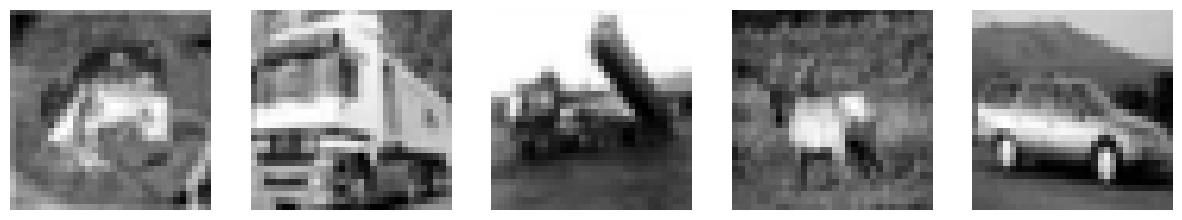

In [28]:
fig, axs = plt.subplots(1, 5, figsize=(15, 5))

for i in range(5):
    y_pred = model.predict(Xtr[i].reshape(-1,3))
    axs[i].imshow(y_pred.reshape(32,32),cmap="gray")
    axs[i].axis(False)
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step


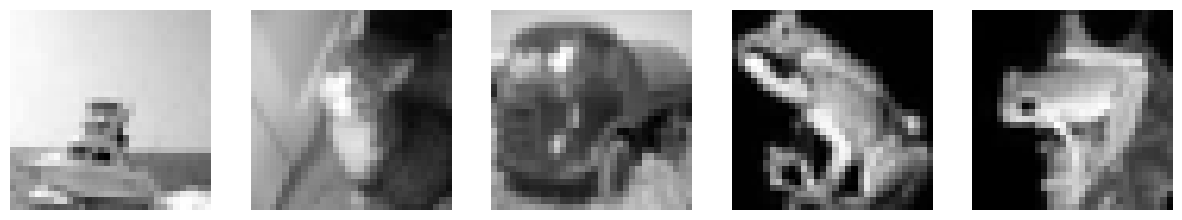

In [29]:
fig, axs = plt.subplots(1, 5, figsize=(15, 5))

for i in range(5):
    y_pred = model.predict(Xval[i].reshape(-1,3))
    axs[i].imshow(y_pred.reshape(32,32),cmap="gray")
    axs[i].axis(False)
plt.show()

# Morphological Operators for Color Images

In [31]:
def h_model(model):
    def aux(img):
        return model.predict(img.reshape(-1,3)).reshape(img.shape[0],img.shape[1])
    return aux

def h_average(rho_list):
    def aux(img):
        return np.mean(np.stack([rho(img) for rho in rho_list],axis=2),axis=2)
    return aux

# h-moprhological operator

def hMM(I, h = h_model(model), mm_op = dilation, SE = square(7)):
    nr,nc,nb = I.shape
    Data=np.reshape(I,[nr*nc,nb])
    horder = h(I).flatten()
    order = np.argsort(horder[:])
    latt = np.zeros(Data.shape[0],dtype=np.int32)
    latt[order] = np.arange(Data.shape[0])
    latt = np.reshape(latt,[nr,nc])
    mm_latt = mm_op(latt,SE)
    imOut=Data[order[mm_latt],:]
    return np.reshape(imOut,[nr,nc,nb])

/tmp/ipykernel_24429/4017338546.py:13: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  def hMM(I, h = h_model(model), mm_op = dilation, SE = square(7)):


# Irregularity Index

In [33]:
def global_irregularity(imI,imJ,metric='euclidean'):
    M,N,K = imI.shape
    a = imI.reshape(M*N,K)
    b = imJ.reshape(M*N,K)
    vu,hu = np.unique(a,return_counts=True,axis=0)
    vv,hv = np.unique(b,return_counts=True,axis=0)
    C = pairwise_distances(vu,vv,metric=metric)
    return 1-ot.emd2(1.0*hu,1.0*hv,C)/np.sum(paired_distances(a,b,metric=metric))

# Show morphological operation applied on images from the training set

/tmp/ipykernel_24429/3596821883.py:2: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  SE = square(SE_size)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step


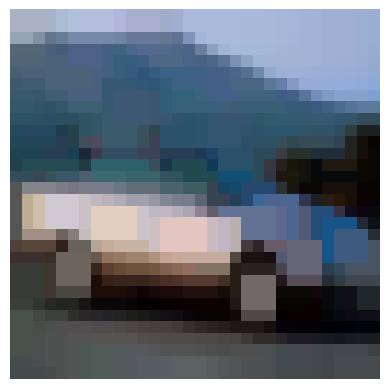

In [35]:
SE_size = 3
SE = square(SE_size)

rho_list = [LexRGB, LexGBR, LexBRG, h_model(model)]
rho_list_names = ["Lex_RGB", "Lex_GBR", "Lex_BRG","Model"]

Irreg = np.zeros((5,len(rho_list)))

for i,x in enumerate(Xtr[:5]):
    for j,rho in enumerate(rho_list):
        img = hMM(x,h=rho, mm_op = opening, SE = SE)
        Irreg[i,j] = 100*global_irregularity(x,img)
        plt.imshow(img)
        plt.axis(False)
        plt.savefig(folder_name+'/open_'+rho_list_names[j]+str(i)+'.png', bbox_inches='tight', dpi=300)
        # plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step


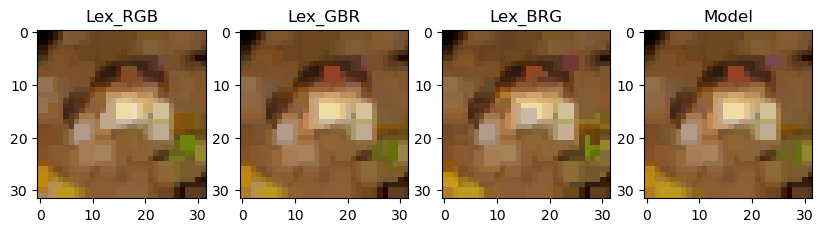

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step


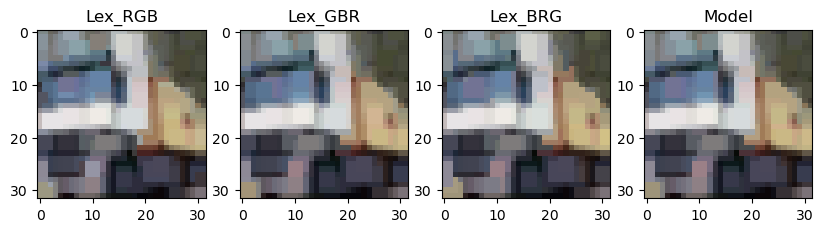

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step


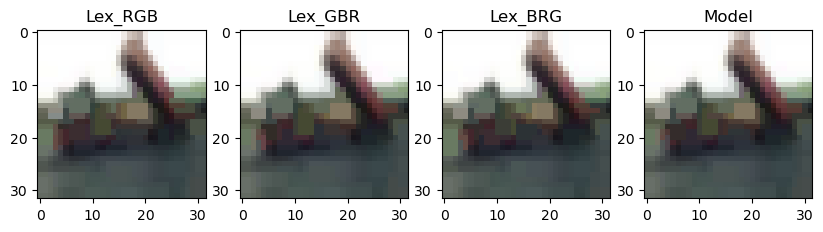

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


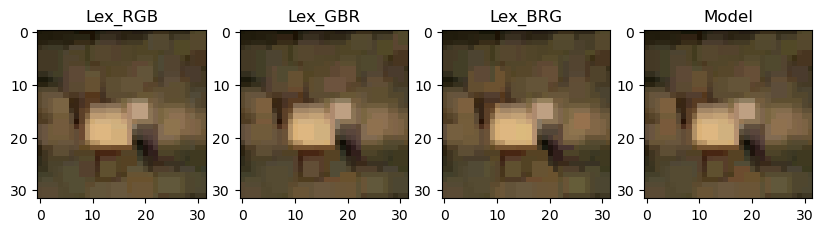

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step


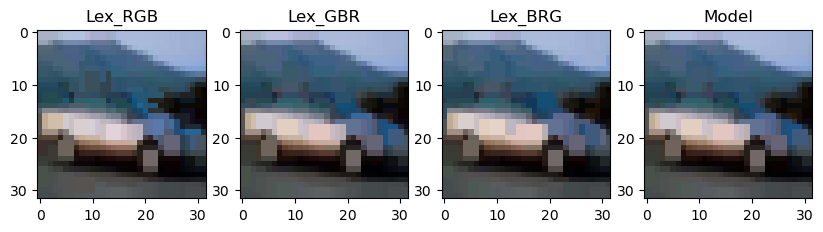

In [36]:
for x in Xtr[:5]:
    fig, axs = plt.subplots(1, 4, figsize=(10, 5))
    for i,rho in enumerate(rho_list):
      axs[i].imshow(hMM(x,h=rho, mm_op = opening, SE = SE))
      axs[i].set_title(rho_list_names[i])
    plt.show()

# Show some images from validation set

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step


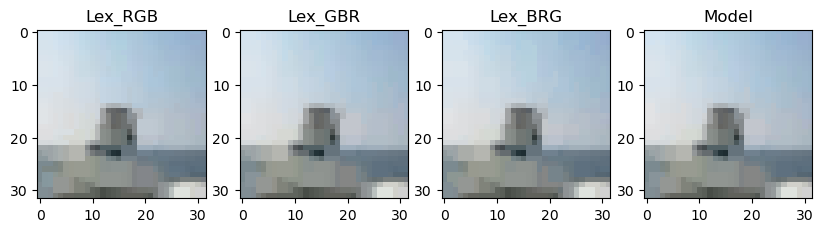

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step


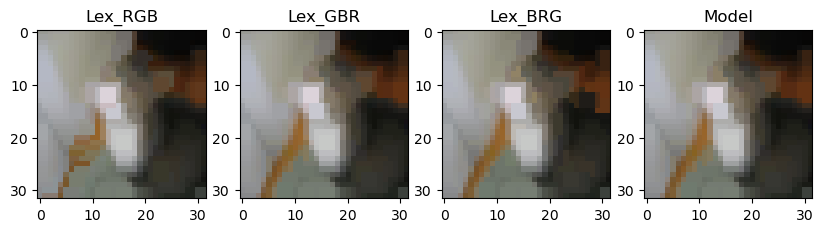

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step


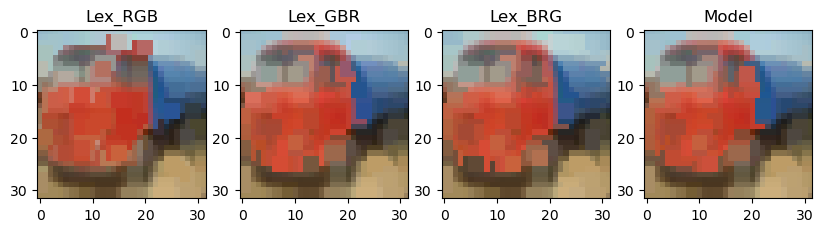

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step


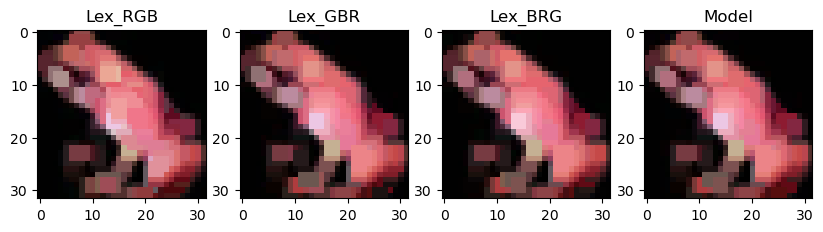

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


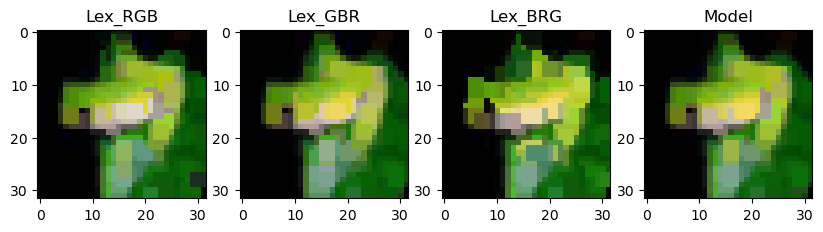

In [38]:
for x in Xval[:5]:
    fig, axs = plt.subplots(1, 4, figsize=(10, 5))
    for i,rho in enumerate(rho_list):
      axs[i].imshow(hMM(x,h=rho, mm_op = opening, SE = SE))
      axs[i].set_title(rho_list_names[i])
    plt.show()

# Compute the Irregularity index in the validation set

In [40]:
Irreg = np.zeros((Xval.shape[0],len(rho_list)))

for i,x in enumerate(Xval):
    for j,rho in enumerate(rho_list):
        img = hMM(x,h=rho, mm_op = opening, SE = SE)
        Irreg[i,j] = global_irregularity(x,img)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step
32/32 ━━━━━━━━━━

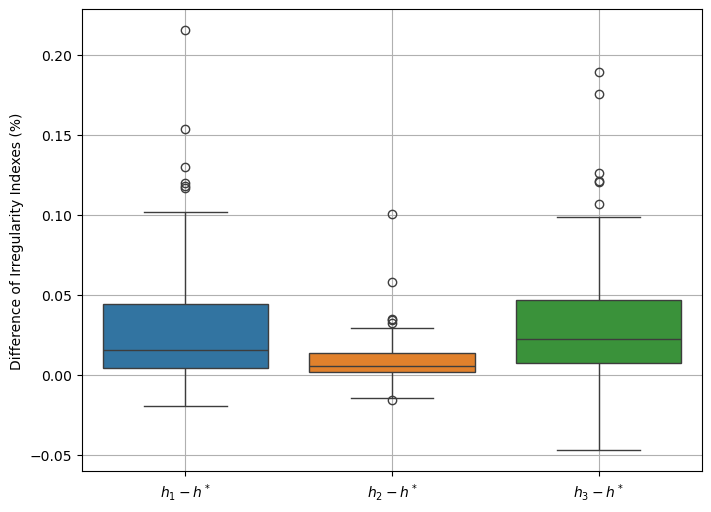

In [41]:
# Convert the numpy array to a pandas DataFrame for seaborn
IrregDif = np.stack([Irreg[:,i]-Irreg[:,3] for i in range(3)],axis=1)

df = pd.DataFrame(IrregDif, columns=["$h_1-h^*$","$h_2-h^*$","$h_3-h^*$"])

plt.figure(figsize=(8, 6))

# Create the box plot using seaborn
sns.boxplot(data=df)

# Add labels and title
plt.ylabel('Difference of Irregularity Indexes (%)')
# plt.title('Box Plot of Features (Seaborn)')
plt.grid()
plt.savefig(folder_name+'/'+'irregularity_values.png', bbox_inches='tight', dpi=300)
plt.show()

# Example using a color image from the BSD dataset

In [43]:
# Create the Images folder if it doesn't exist
folder_name = 'Images'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

image_url = 'https://www.ime.unicamp.br/~valle/Gallery/124084.jpg'  # Corrected URL

try:
    response = requests.get(image_url, stream=True)
    response.raise_for_status()  # Raise an exception for bad status codes

    image = Image.open(response.raw)
    image_path = os.path.join(folder_name, '124084.jpg')
    image.save(image_path)
    print(f"Image downloaded and saved to {image_path}")

except requests.exceptions.RequestException as e:
    print(f"Error downloading image: {e}")
except Exception as e:
    print(f"Error saving image: {e}")


Image downloaded and saved to Images/124084.jpg


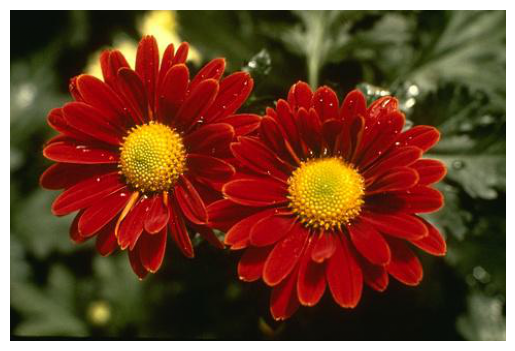

In [44]:
# Load a color image:
image_path = "Images/124084.jpg"  # Replace with the actual path to your image
image = Image.open(image_path)
image = image.resize((image.size[0],image.size[1]))
x = np.array(image)/255

# Display the image
plt.imshow(x)
plt.axis(False)
plt.savefig(folder_name+'/flowers.png', bbox_inches='tight', dpi=300)

4826/4826 ━━━━━━━━━━━━━━━━━━━━ 1s 257us/step


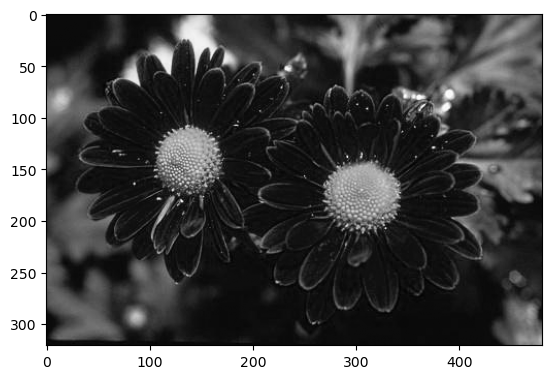

In [45]:
plt.imshow(h_model(model)(x),cmap="gray")

4826/4826 ━━━━━━━━━━━━━━━━━━━━ 1s 232us/step


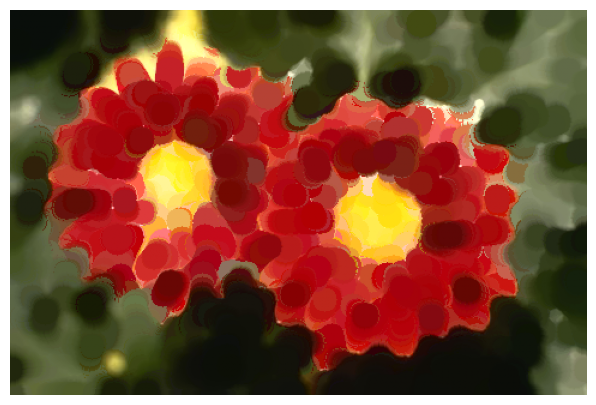

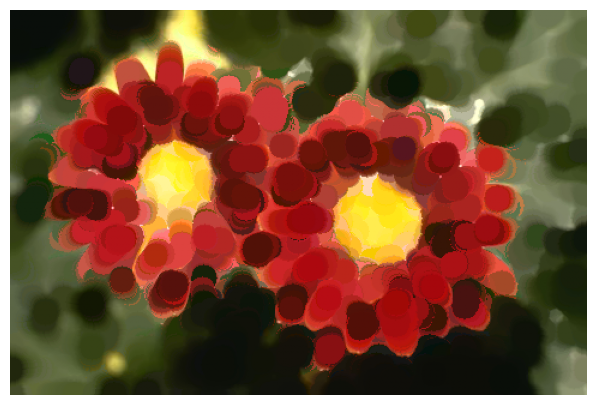

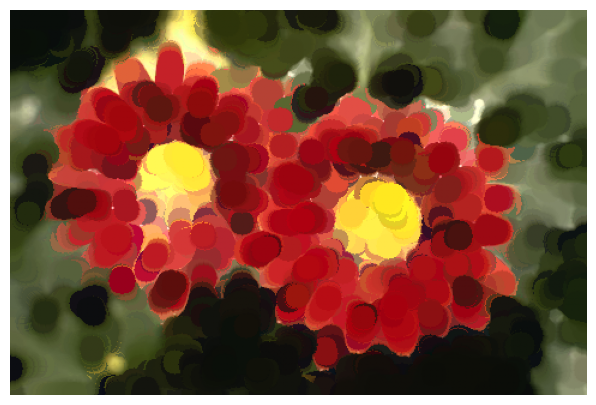

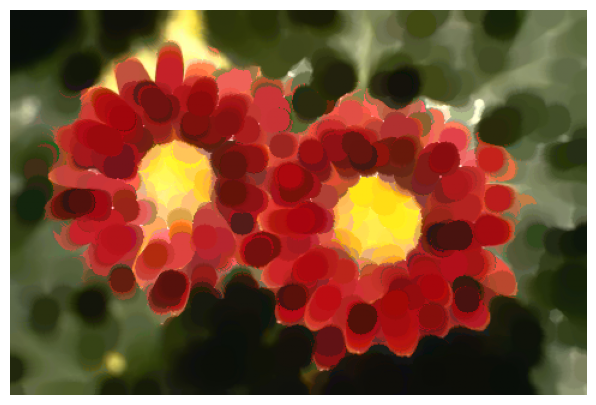

In [46]:
SE = disk(10)
for i,rho in enumerate(rho_list):
    plt.figure(figsize=(10,5))
    plt.imshow(hMM(x,h=rho, mm_op = closing, SE = SE))
    plt.axis(False)
    plt.savefig(folder_name+'/closing_'+rho_list_names[i]+'.png', bbox_inches='tight', dpi=300)
    # plt.show()

# Show the color orderings

Color elements - NOT ORDERED!


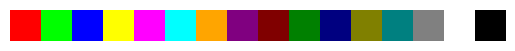

In [48]:
# Generate a 4x4 color image
image = np.zeros((4, 4, 3))

# Assign colors to each pixel
image[0, 0] = [255, 0, 0]      # Red
image[0, 1] = [0, 255, 0]      # Light Green
image[0, 2] = [0, 0, 255]      # Blue
image[0, 3] = [255, 255, 0]    # Yellow
image[1, 0] = [255, 0, 255]    # Magenta
image[1, 1] = [0, 255, 255]    # Cyan
image[1, 2] = [255, 165, 0]    # Orange
image[1, 3] = [128, 0, 128]    # Purple
image[2, 0] = [128, 0, 0]      # Maroon
image[2, 1] = [0, 128, 0]      # Dark Green
image[2, 2] = [0, 0, 128]      # Navy
image[2, 3] = [128, 128, 0]    # Olive
image[3, 0] = [0, 128, 128]    # Teal
image[3, 1] = [128, 128, 128]  # Gray
image[3, 2] = [255, 255, 255]  # White
image[3, 3] = [0, 0, 0]       # Black

color_names = [
    "Red",
    "Light Green",
    "Blue",
    "Yellow",
    "Magenta",
    "Cyan",
    "Orange",
    "Purple",
    "Maroon",
    "Dark Green",
    "Navy",
    "Olive",
    "Teal",
    "Gray",
    "White",
    "Black"
]


image = image/255  # Normalize pixel values to the range [0, 1]

# Display the color elements
print("Color elements - NOT ORDERED!")
[M,N,K] = image.shape
plt.imshow(image.reshape(1,M*N,K))
plt.axis('off') # Hide axes
plt.savefig(folder_name+'/colors.png', bbox_inches='tight', dpi=300)
plt.show()

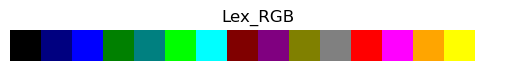

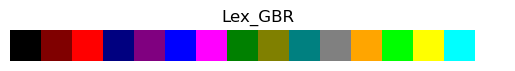

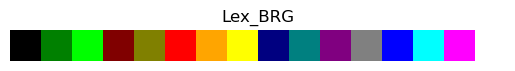

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


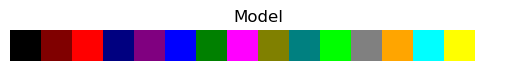

In [49]:
# fig, axs = plt.subplots(4, 1, figsize=(10, 5))

x = image
[M,N,K] = x.shape
for i,rho in enumerate(rho_list):
    ind = np.argsort(rho(x).flatten())
    im_sorted = (x.reshape(M*N,3)[ind,:]).reshape(1,M*N,K)
    plt.imshow(im_sorted)
    plt.axis(False)
    plt.savefig(folder_name+'/colors_'+rho_list_names[i]+'.png', bbox_inches='tight', dpi=300)
    plt.title(rho_list_names[i])
    plt.show()

In [50]:
ind = np.argsort(h_model(model)(x).flatten())
print("h^* color ranking:")
[color_names[i] for i in ind]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
h^* color ranking:


['Black',
 'Maroon',
 'Red',
 'Navy',
 'Purple',
 'Blue',
 'Dark Green',
 'Magenta',
 'Olive',
 'Teal',
 'Light Green',
 'Gray',
 'Orange',
 'Cyan',
 'Yellow',
 'White']

# Show the path of the color rank in the 3d space

This is nice but difficult to interpret!

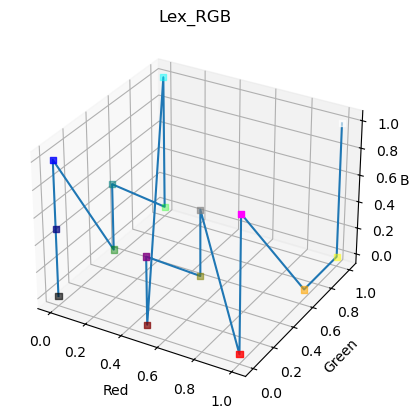

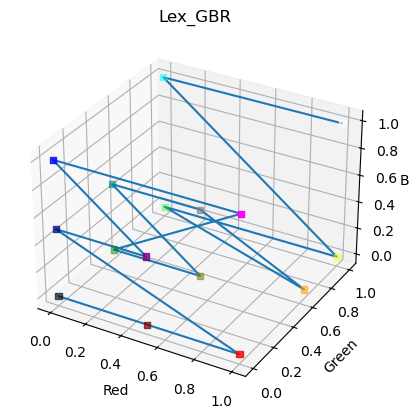

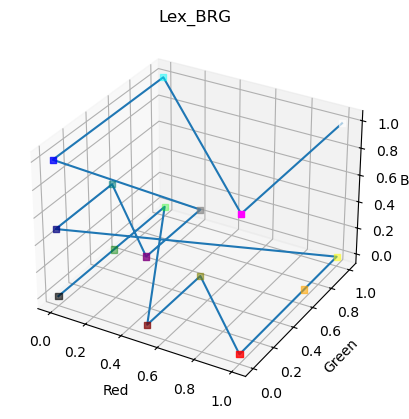

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


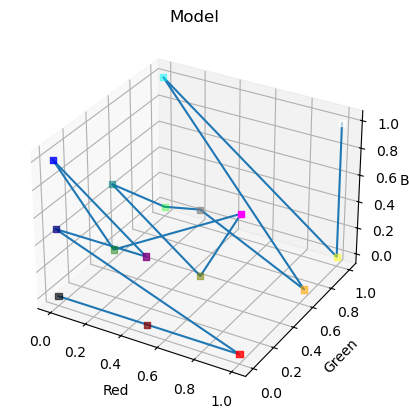

In [52]:
x = image
[M,N,K] = x.shape
for i,rho in enumerate(rho_list):
    ind = np.argsort(rho(x).flatten())
    im_sorted = (x.reshape(M*N,3)[ind,:]).reshape(M*N,K)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot of the colors
    ax.plot(im_sorted[:, 0], im_sorted[:, 1], im_sorted[:, 2])
    ax.scatter(im_sorted[:, 0], im_sorted[:, 1], im_sorted[:, 2], color=im_sorted, marker='s')

    # Set axis labels
    ax.set_xlabel('Red')
    ax.set_ylabel('Green')
    ax.set_zlabel('Blue')
    ax.set_title(rho_list_names[i])

    # Show the plot
    plt.show()